In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.width', 1000)

In [2]:
symbol = 'IBM'
start_day = '1999-01-01'

In [3]:
ticker = yf.Ticker(symbol)
IBM_history = ticker.history(start=start_day)

IBM_history.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

IBM_history['Prev_close'] = IBM_history['Close'].shift()
IBM_history['Rate'] = (IBM_history['Close'] - IBM_history['Prev_close']) / IBM_history['Prev_close'] * 100
IBM_history['Rate'][0] = (IBM_history['Close'][0] - IBM_history['Open'][0]) / IBM_history['Open'][0] * 100

IBM_history.reset_index(inplace=True)
IBM_history['Date'] = IBM_history['Date'].dt.strftime('%Y-%m-%d')
IBM_history.set_index(IBM_history['Date'], inplace=True)
IBM_history.drop(['Date', 'Prev_close'], axis=1, inplace=True)

c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
window_size = 20
data_rolling = IBM_history['Close'].rolling(window_size, min_periods=1)
IBM_history[f'MA_{window_size}'] = data_rolling.mean().astype(np.int32)

In [5]:
IBM_history['Upper Band'] = IBM_history[f'MA_{window_size}'] + (2 * data_rolling.std())
IBM_history['Lower Band'] = IBM_history[f'MA_{window_size}'] - (2 * data_rolling.std())
IBM_history['Upper Band'][0] = IBM_history[f'MA_{window_size}'][0] + (2 * np.std([IBM_history['Open'][0], IBM_history['Close'][0]]))
IBM_history['Lower Band'][0] = IBM_history[f'MA_{window_size}'][0] - (2 * np.std([IBM_history['Open'][0], IBM_history['Close'][0]]))

IBM_history['Upper Band'] = IBM_history['Upper Band'].round(2)
IBM_history['Lower Band'] = IBM_history['Lower Band'].round(2)

IBM_history.drop(f'MA_{window_size}', axis=1, inplace=True)

c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [6]:
sp500 = yf.Ticker('^GSPC')
sp500_history = sp500.history(start=start_day)

sp500_history.reset_index(inplace=True)
sp500_history['Date'] = sp500_history['Date'].dt.strftime('%Y-%m-%d')
sp500_history.set_index(sp500_history['Date'], inplace=True)
sp500_history.drop(['Date'], axis=1, inplace=True)

sp500_history.rename({'Close':'SP500'}, axis=1, inplace=True)

In [7]:
nasdaq = yf.Ticker('^IXIC')
nasdaq_history = nasdaq.history(start=start_day)

nasdaq_history.reset_index(inplace=True)
nasdaq_history['Date'] = nasdaq_history['Date'].dt.strftime('%Y-%m-%d')
nasdaq_history.set_index(nasdaq_history['Date'], inplace=True)
nasdaq_history.drop(['Date'], axis=1, inplace=True)

nasdaq_history.rename({'Close':'Nasdaq'}, axis=1, inplace=True)

In [8]:
data = pd.concat([IBM_history, sp500_history['SP500'].round(2), nasdaq_history['Nasdaq'].round(2)], axis=1)

In [9]:
data

,Open,High,Low,Close,Volume,Rate,Upper Band,Lower Band,SP500,Nasdaq
Date,,,,,,,,,,
1999-01-04,50.220333,50.627526,49.270218,49.677410,8524482,-1.081082,49.54,48.46,1228.10,2208.05
1999-01-05,49.677470,51.543770,49.626574,51.475903,10363350,3.620343,52.54,47.46,1244.78,2251.27
1999-01-06,51.662494,52.324182,51.170471,51.238335,9978422,-0.461513,51.95,48.05,1272.34,2320.86
1999-01-07,51.017795,52.222406,50.763300,51.628582,8688913,0.761632,52.80,49.20,1269.73,2326.09
1999-01-08,51.849119,52.120581,50.390013,50.915970,9598933,-1.380267,51.56,48.44,1275.09,2344.41
...,...,...,...,...,...,...,...,...,...,...
2023-02-08,134.063289,135.080790,133.519960,134.330002,4593700,0.103066,145.13,128.87,4117.86,11910.52
2023-02-09,134.990005,135.729996,133.339996,133.750000,3918800,-0.431774,143.77,128.23,4081.50,11789.58
2023-02-10,133.779999,135.770004,133.500000,135.600006,5049300,1.383182,143.10,128.90,4090.46,11718.12


[]

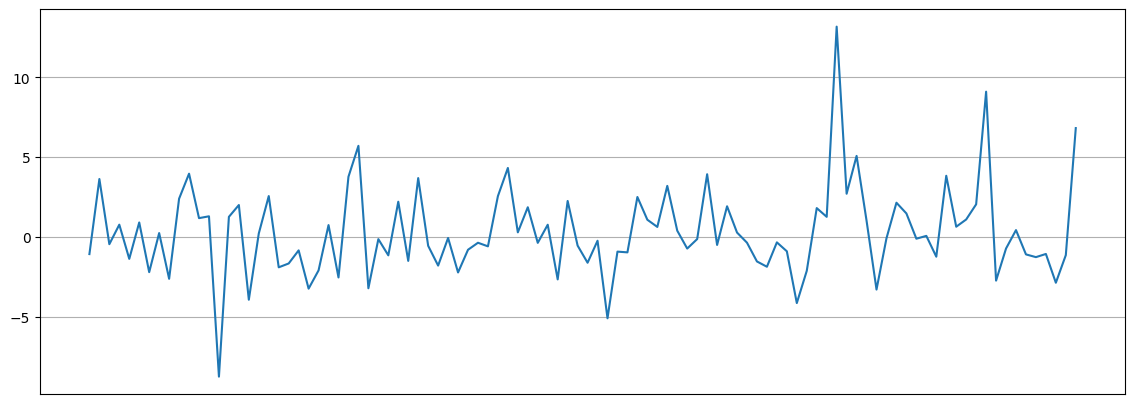

In [10]:
plt.figure(figsize=(14,5))
plt.plot(data['Rate'][:100])
plt.grid()
plt.gca().axes.xaxis.set_visible(False)
plt.plot()

In [18]:
data_rate = data.copy()
data_rate.drop(['Rate'], axis=1, inplace=True)
data.drop(['Rate'], axis=1, inplace=True)

In [23]:
for index in range(1, len(data_rate)):
    data_rate.iloc[index] = (data.iloc[index]-data.iloc[index-1])/data.iloc[index-1] * 100
data_rate = data_rate.iloc[1:]

,Open,High,Low,Close,Volume,Upper Band,Lower Band,SP500,Nasdaq
Date,,,,,,,,,
1999-01-04,50.220333,50.627526,49.270218,49.677410,8.524482e+06,49.540000,48.460000,1228.100000,2208.050000
1999-01-05,-1.080962,1.809775,0.723269,3.620343,2.157161e+01,6.055713,-2.063558,1.358196,1.957383
1999-01-06,3.995823,1.514075,3.111029,-0.461513,-3.714320e+00,-1.122954,1.243152,2.214046,3.091144
1999-01-07,-1.247906,-0.194509,-0.795715,0.761632,-1.292298e+01,1.636189,2.393340,-0.205134,0.225348
1999-01-08,1.629478,-0.194985,-0.735348,-1.380267,1.047335e+01,-2.348485,-1.544715,0.422137,0.787588
...,...,...,...,...,...,...,...,...,...
2023-02-08,0.029493,0.249279,0.528086,0.103066,2.290507e+01,-0.151359,0.171007,-1.108069,-1.678005
2023-02-09,0.691253,0.480606,-0.134784,-0.431774,-1.469186e+01,-0.937091,-0.496625,-0.882983,-1.015405
2023-02-10,-0.896368,0.029477,0.119997,1.383182,2.884812e+01,-0.466022,0.522499,0.219527,-0.606128


In [11]:
# train_data = data[:int(len(data)*0.8)]
# test_data = data[int(len(data)*0.8):]

# time_len = 128
# X_train, y_train = [], []
# for i in range(time_len, len(train_data)):
#   X_train.append(train_data[i-time_len:i]) # Chunks of training data with a length of 128 df-rows
#   y_train.append(train_data['Close'][i]) #Value of 4th column (Close Price) of df-row 128+1
# X_train, y_train = np.array(X_train, dtype=np.float32), np.array(y_train, dtype=np.float32)

# X_test, y_test = [], []
# for i in range(time_len, len(test_data)):
#   X_test.append(test_data[i-time_len:i]) # Chunks of training data with a length of 128 df-rows
#   y_test.append(test_data['Close'][i]) #Value of 4th column (Close Price) of df-row 128+1
# X_test, y_test = np.array(X_test, dtype=np.float32), np.array(y_test, dtype=np.float32)


In [12]:
# from keras.layers import LSTM, Input, Dense, Dropout
# from keras.models import Sequential
# from keras.callbacks import EarlyStopping

# model = Sequential([
#     Input(shape=(time_len, len(data.columns))),
#     LSTM(256, return_sequences=True),
#     Dropout(0.1),
#     LSTM(64),
#     Dense(1),
# ])

# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

# es = EarlyStopping(monitor='mape', patience=2)

# model.fit(X_train, y_train, batch_size=64, epochs=30, callbacks=[es])

In [13]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14,5))
# plt.plot(y_test, label='True')
# plt.plot(model.predict(X_test, verbose=0), label='Pred')
# plt.grid()
# plt.legend()
# plt.show()

In [14]:
from keras import backend as K
from keras.layers import Concatenate
from keras.layers import Input, Dense, Lambda, Subtract, Add, Reshape
from keras.models import Model


def smape_loss(y_true, y_pred):
    """
    sMAPE loss as defined in "Appendix A" of
    http://www.forecastingprinciples.com/files/pdf/Makridakia-The%20M3%20Competition.pdf
    :return: Loss value
    """
    # mask=tf.where(y_true,1.,0.)
    mask = tf.cast(y_true, tf.bool)
    mask = tf.cast(mask, tf.float32)
    sym_sum = tf.abs(y_true) + tf.abs(y_pred)
    condition = tf.cast(sym_sum, tf.bool)
    weights = tf.where(condition, 1. / (sym_sum + 1e-8), 0.0)
    return tf.convert_to_tensor(200 * np.nanmean(tf.abs(y_pred - y_true) * weights * mask))
    # return np.mean((np.abs(y_true-y_pred))/(np.abs(y_true) + np.abs(y_pred)))


class NBeatsNet:
    GENERIC_BLOCK = 'generic'
    TREND_BLOCK = 'trend'
    SEASONALITY_BLOCK = 'seasonality'

    _BACKCAST = 'backcast'
    _FORECAST = 'forecast'

    def __init__(self,
                 input_dim=1,
                 output_dim=1,
                 exo_dim=0,
                 backcast_length=10,
                 forecast_length=1,
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 thetas_dim=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None):

        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.thetas_dim = thetas_dim
        self.units = hidden_layer_units
        self.share_weights_in_stack = share_weights_in_stack
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.exo_dim = exo_dim
        self.input_shape = (self.backcast_length, self.input_dim)
        self.exo_shape = (self.backcast_length, self.exo_dim)
        self.output_shape = (self.forecast_length, self.output_dim)
        self.weights = {}
        self.nb_harmonics = nb_harmonics
        self._gen_intermediate_outputs = False
        self._intermediary_outputs = []
        assert len(self.stack_types) == len(self.thetas_dim)

        x = Input(shape=self.input_shape, name='input_variable')
        x_ = {}
        for k in range(self.input_dim):
            x_[k] = Lambda(lambda z: z[..., k])(x)
        e_ = {}
        if self.has_exog():
            e = Input(shape=self.exo_shape, name='exos_variables')
            for k in range(self.exo_dim):
                e_[k] = Lambda(lambda z: z[..., k])(e)
        else:
            e = None
        y_ = {}

        for stack_id in range(len(self.stack_types)):
            stack_type = self.stack_types[stack_id]
            nb_poly = self.thetas_dim[stack_id]
            for block_id in range(self.nb_blocks_per_stack):
                backcast, forecast = self.create_block(x_, e_, stack_id, block_id, stack_type, nb_poly)
                for k in range(self.input_dim):
                    x_[k] = Subtract()([x_[k], backcast[k]])
                    layer_name = f'stack_{stack_id}-{stack_type.title()}Block_{block_id}'
                    if self.input_dim >= 1:
                        layer_name += f'_Dim_{k}'
                    # rename.
                    forecast[k] = Lambda(function=lambda _x: _x, name=layer_name)(forecast[k])
                    if stack_id == 0 and block_id == 0:
                        y_[k] = forecast[k]
                    else:
                        y_[k] = Add()([y_[k], forecast[k]])

        for k in range(self.input_dim):
            y_[k] = Reshape(target_shape=(self.forecast_length, 1))(y_[k])
            x_[k] = Reshape(target_shape=(self.backcast_length, 1))(x_[k])
        if self.input_dim > 1:
            y_ = Concatenate()([y_[ll] for ll in range(self.input_dim)])
            x_ = Concatenate()([x_[ll] for ll in range(self.input_dim)])
        else:
            y_ = y_[0]
            x_ = x_[0]

        if self.input_dim != self.output_dim:
            y_ = Dense(self.output_dim, activation='linear', name='reg_y')(y_)
            x_ = Dense(self.output_dim, activation='linear', name='reg_x')(x_)

        inputs_x = [x, e] if self.has_exog() else x
        n_beats_forecast = Model(inputs_x, y_, name=self._FORECAST)
        n_beats_backcast = Model(inputs_x, x_, name=self._BACKCAST)

        self.models = {model.name: model for model in [n_beats_backcast, n_beats_forecast]}
        self.cast_type = self._FORECAST

    def get_generic_and_interpretable_outputs(self):
        g_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' in a['layer'].lower()])
        i_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' not in a['layer'].lower()])
        outputs = {o['layer']: o['value'][0] for o in self._intermediary_outputs}
        return g_pred, i_pred, outputs

    def has_exog(self):
        # exo/exog is short for 'exogenous variable', i.e. any input
        # features other than the target time-series itself.
        return self.exo_dim > 0

    @staticmethod
    def name():
        return 'NBeatsKeras'

    @staticmethod
    def load(filepath, custom_objects=None, compile=True):
        from keras.models import load_model
        return load_model(filepath, custom_objects, compile)

    def _r(self, layer_with_weights, stack_id):
        # mechanism to restore weights when block share the same weights.
        # only useful when share_weights_in_stack=True.
        if self.share_weights_in_stack:
            layer_name = layer_with_weights.name.split('/')[-1]
            try:
                reused_weights = self.weights[stack_id][layer_name]
                return reused_weights
            except KeyError:
                pass
            if stack_id not in self.weights:
                self.weights[stack_id] = {}
            self.weights[stack_id][layer_name] = layer_with_weights
        return layer_with_weights

    def disable_intermediate_outputs(self):
        self._gen_intermediate_outputs = False

    def enable_intermediate_outputs(self):
        self._gen_intermediate_outputs = True

    def create_block(self, x, e, stack_id, block_id, stack_type, nb_poly):
        # register weights (useful when share_weights_in_stack=True)
        def reg(layer):
            return self._r(layer, stack_id)

        # update name (useful when share_weights_in_stack=True)
        def n(layer_name):
            return '/'.join([str(stack_id), str(block_id), stack_type, layer_name])

        backcast_ = {}
        forecast_ = {}
        d1 = reg(Dense(self.units, activation='relu', name=n('d1')))
        d2 = reg(Dense(self.units, activation='relu', name=n('d2')))
        d3 = reg(Dense(self.units, activation='relu', name=n('d3')))
        d4 = reg(Dense(self.units, activation='relu', name=n('d4')))
        if stack_type == 'generic':
            theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = reg(Dense(self.backcast_length, activation='linear', name=n('backcast')))
            forecast = reg(Dense(self.forecast_length, activation='linear', name=n('forecast')))
        elif stack_type == 'trend':
            theta_f = theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f_b')))
            backcast = Lambda(trend_model, arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
            forecast = Lambda(trend_model, arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
        else:  # 'seasonality'
            if self.nb_harmonics:
                theta_b = reg(Dense(self.nb_harmonics, activation='linear', use_bias=False, name=n('theta_b')))
            else:
                theta_b = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = Lambda(seasonality_model,
                              arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
            forecast = Lambda(seasonality_model,
                              arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
        for k in range(self.input_dim):
            if self.has_exog():
                d0 = Concatenate()([x[k]] + [e[ll] for ll in range(self.exo_dim)])
            else:
                d0 = x[k]
            d1_ = d1(d0)
            d2_ = d2(d1_)
            d3_ = d3(d2_)
            d4_ = d4(d3_)
            theta_f_ = theta_f(d4_)
            theta_b_ = theta_b(d4_)
            backcast_[k] = backcast(theta_b_)
            forecast_[k] = forecast(theta_f_)

        return backcast_, forecast_

    def __getattr__(self, name):
        # https://github.com/faif/python-patterns
        # model.predict() instead of model.n_beats.predict()
        # same for fit(), train_on_batch()...
        attr = getattr(self.models[self._FORECAST], name)

        if not callable(attr):
            return attr

        def wrapper(*args, **kwargs):
            cast_type = self._FORECAST
            if attr.__name__ == 'predict' and 'return_backcast' in kwargs and kwargs['return_backcast']:
                del kwargs['return_backcast']
                cast_type = self._BACKCAST

            if attr.__name__ == 'predict' and self._gen_intermediate_outputs:
                import keract
                outputs = keract.get_activations(model=self, x=args)
                self._intermediary_outputs = [
                    {'layer': a, 'value': b} for a, b in outputs.items() if str(a).startswith('stack_')
                ]
            return getattr(self.models[cast_type], attr.__name__)(*args, **kwargs)

        return wrapper


def linear_space(backcast_length, forecast_length, is_forecast=True):
    # ls = K.arange(-float(backcast_length), float(forecast_length), 1) / forecast_length
    # return ls[backcast_length:] if is_forecast else K.abs(K.reverse(ls[:backcast_length], axes=0))
    horizon = forecast_length if is_forecast else backcast_length
    return K.arange(0, horizon) / horizon


def seasonality_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.get_shape().as_list()[-1]
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    s1 = K.stack([K.cos(2 * np.pi * i * t) for i in range(p1)])
    s2 = K.stack([K.sin(2 * np.pi * i * t) for i in range(p2)])
    if p == 1:
        s = s2
    else:
        s = K.concatenate([s1, s2], axis=0)
    s = K.cast(s, np.float32)
    return K.dot(thetas, s)


def trend_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.shape[-1]
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    t = K.transpose(K.stack([t ** i for i in range(p)]))
    t = K.cast(t, np.float32)
    return K.dot(thetas, K.transpose(t))

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

num_rows = len(data)
num_columns = len(data.columns)
forecast_length = 20
backcast_length = 3 * forecast_length

def make_X_y(data):
    X, y = [], []
    for i in range(backcast_length, len(data)-forecast_length+1):
        X.append(data[i-backcast_length:i]) # Chunks of training data with a length of 128 df-rows
        y.append(data['Rate'][i:i+forecast_length]) #Value of 4th column (Close Price) of df-row 128+1
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    return X, y

def split_train_val_test(data, percent):
    train_data = data[:int(len(data)*percent[0])]
    val_data = data[int(len(data)*percent[0]):int(len(data)*percent[1])]
    test_data = data[int(len(data)*percent[1]):]
    X_train, y_train = make_X_y(train_data)
    X_val, y_val = make_X_y(val_data)
    X_test, y_test = make_X_y(test_data)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_train_val_test(data, (0.7, 0.9))


# noinspection PyArgumentEqualDefault
model = NBeatsNet(
    input_dim=num_columns,
    output_dim=1,
    forecast_length=forecast_length,
    backcast_length=backcast_length,
    nb_blocks_per_stack=4,
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK),
    thetas_dim=(4, 8, 8),
)
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

es = EarlyStopping(monitor='val_loss', patience=5)
cp = ModelCheckpoint(f'./model/train/nbeats_rate_{symbol}.h5', monitor='val_loss', save_best_only=True)

In [16]:
history = model.fit(X_train, y_train, epochs=30, callbacks=[es, cp], validation_data=(X_val, y_val))

Epoch 1/30
131/131 [==============================] - 66s 312ms/step - loss: 806.1795 - mse: 9680495.0000 - val_loss: 608.7021 - val_mse: 524601.1875
Epoch 2/30
131/131 [==============================] - 32s 246ms/step - loss: 148.0011 - mse: 40131.9453 - val_loss: 474.6987 - val_mse: 418371.8125
Epoch 3/30
131/131 [==============================] - 32s 248ms/step - loss: 111.3670 - mse: 22703.3398 - val_loss: 209.8551 - val_mse: 88006.0859
Epoch 4/30
131/131 [==============================] - 32s 244ms/step - loss: 93.5578 - mse: 15467.9395 - val_loss: 316.9498 - val_mse: 139590.2656
Epoch 5/30
131/131 [==============================] - 33s 251ms/step - loss: 74.1666 - mse: 10555.8652 - val_loss: 144.1712 - val_mse: 33645.3242
Epoch 6/30
131/131 [==============================] - 33s 250ms/step - loss: 54.8305 - mse: 5360.7036 - val_loss: 149.4040 - val_mse: 35064.0938
Epoch 7/30
131/131 [==============================] - 33s 250ms/step - loss: 44.5821 - mse: 3712.4924 - val_loss: 62.

In [17]:
# model = model.load_weights('./model/train/nbeats_rate.h5')

In [18]:
model.evaluate(X_test, y_test)

17/17 [==============================] - 2s 94ms/step - loss: 1.6177 - mse: 4.4086


[1.6176996231079102, 4.408560752868652]

[]

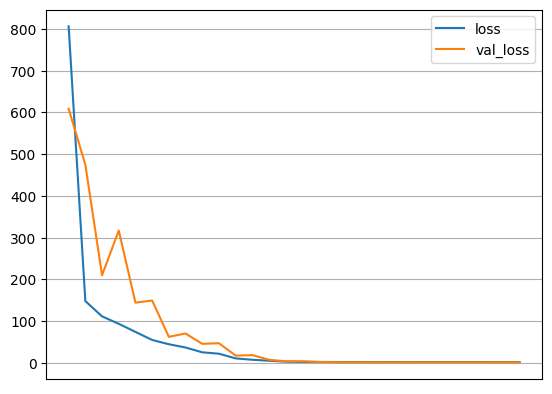

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.gca().axes.xaxis.set_visible(False)
plt.plot()

In [20]:
if forecast_length == 1:
    pred = model.predict(X_test, verbose=0)       #forecast_length = 1 -> pred.shape = (n, )
else:
    pred = model.predict(X_test, verbose=0).squeeze()

full_pred = np.full((len(pred), len(pred[0])+len(pred)-1), np.nan)
for index, value in enumerate(pred):
    full_pred[index][index:index+forecast_length] = value
full_pred_mean = np.nanmean(full_pred, axis=0)

y_true = data[int(len(data)*0.9):]['Rate'][backcast_length:]

[]

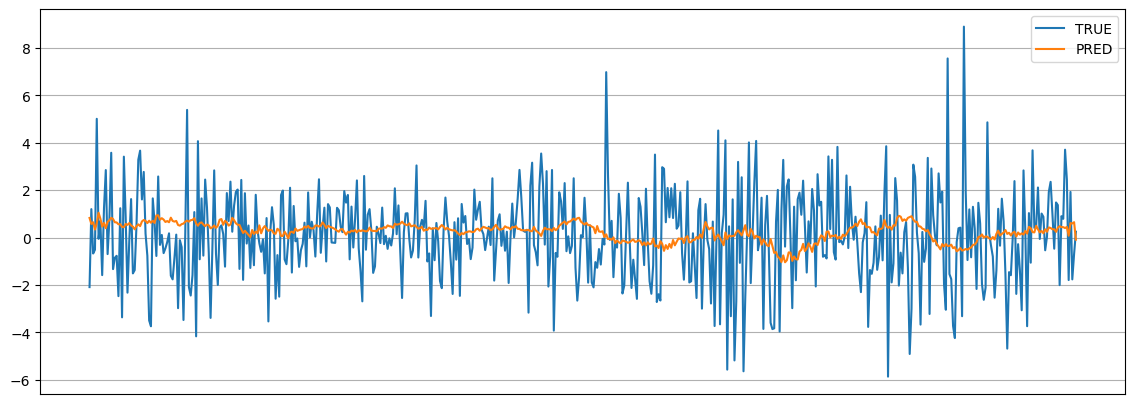

In [21]:
plt.figure(figsize=(14,5))
plt.plot(y_true, label='TRUE')
plt.plot(full_pred_mean, label='PRED')
plt.legend()
plt.grid()
plt.gca().axes.xaxis.set_visible(False)
plt.plot()

[]

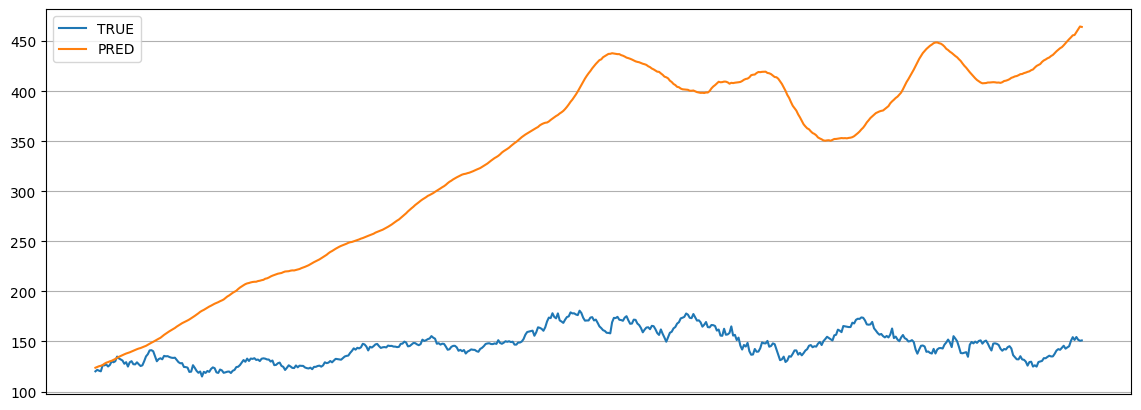

In [22]:
pred_close = []
prev_close = data['Close'][int(len(data)*0.9)+backcast_length-1]
for i in range(len(full_pred_mean)):
    pred_close.append((full_pred_mean[i]/100 + 1) * prev_close)
    prev_close *= (full_pred_mean[i]/100 + 1)

pred_close = np.array(pred_close, dtype=np.float32)
y_true_close = np.array(data['Close'][int(len(data)*0.9)+backcast_length:])

plt.figure(figsize=(14,5))
plt.plot(y_true_close, label='TRUE')
plt.plot(pred_close, label='PRED')
plt.title('X_test_Prediction')
plt.legend()
plt.grid()
plt.gca().axes.xaxis.set_visible(False)
plt.plot()

[]

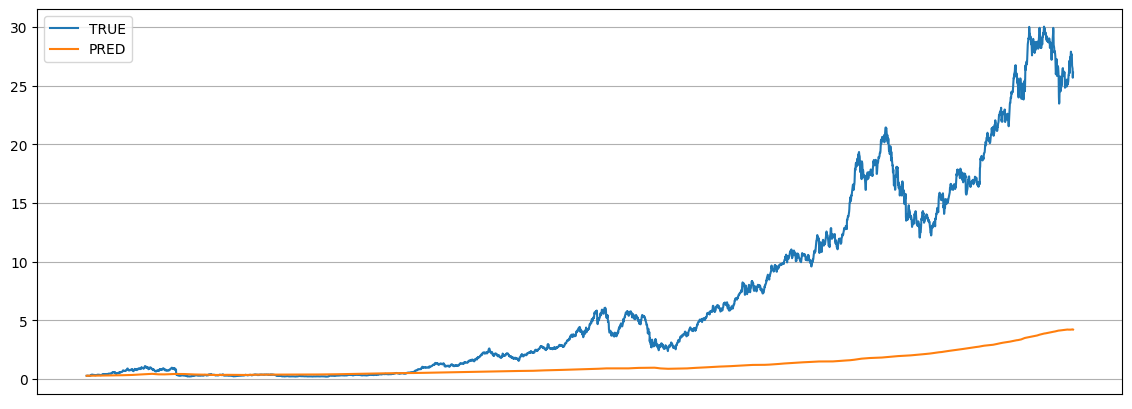

In [23]:
if forecast_length == 1:
    pred = model.predict(X_train, verbose=0)       #forecast_length = 1 -> pred.shape = (n, )
else:
    pred = model.predict(X_train, verbose=0).squeeze()

full_pred = np.full((len(pred), len(pred[0])+len(pred)-1), np.nan)
for index, value in enumerate(pred):
    full_pred[index][index:index+forecast_length] = value
full_pred_mean = np.nanmean(full_pred, axis=0)

y_true = data[:int(len(data)*0.7)]['Rate'][backcast_length:]

pred_close = []
prev_close = data['Close'][backcast_length-1]
for i in range(len(full_pred_mean)):
    pred_close.append((full_pred_mean[i]/100 + 1) * prev_close)
    prev_close *= (full_pred_mean[i]/100 + 1)

pred_close = np.array(pred_close, dtype=np.float32)
y_true_close = np.array(data['Close'][backcast_length:int(len(data)*0.7)])

plt.figure(figsize=(14,5))
plt.plot(y_true_close, label='TRUE')
plt.plot(pred_close, label='PRED')
plt.plot('X_train_prediction')
plt.legend()
plt.grid()
plt.gca().axes.xaxis.set_visible(False)
plt.plot()